# I- Introduction:
Aprés avoir testé the state of the art model (Bert) nous alllons essayer dans ce projet d'utiliser deux types différents de deep neural network: Convolutional Neural Network (CNN) et Long Short Term Memory Network (LSTM), qui est une variante des Recurrent Neural Networks pour affiner rapidement et efficacement un modèle de classification des logs de Blue Gene/L supercompute, où notre objectif sera de détecter les anomalies dans des futurs logs.

* **Dataset** - nous allons utiliser une DT open Source des logs de Blue Gene/L supercomputer(contient 4,747,963 logs mais nous allons utiliser seulement 172K logs),il est sous forme d'un Filelog donc on avait besoin d'utiliser excel(On peut utiliser Python mais excel reste simple) pour insérer les logs dans des dataframes.

* **Objectif** - developper une solution qui permet de detecter les anomalies dans les logs.

* **Methodologie** - nous allons considerer comme nous avons un probleme de text classification et construire un deep learning model pour attiendre l'objectif.

# II- Different Models:

Il existe plusieurs types de modèles qui pourraient être utilisés pour créer la solution de la classification de texte parmi ces solutions on trouve:


*   **1D- Conv Net** : 
les CNN peuvent être utilisés pour la classification des textes. ils sont plus rapides à s'entraîner.

*   **Modèles basés sur RNN (LSTM, GRU)** :  ils peuvent capturer la nature séquentielle d'un texte. Mais ils sont plus lent à s'entraîner.

* **Modèles basés sur des transformers (BERT, GPT2)** -
Les modèles basés sur des transformers exploite plusieurs unités Transformer et un mécanisme d'attention à multihead.

####Dans ce projet nous allons focaliser sur un model basé sur RNN(LSTM) et un autre basé sur les CNN.


# III- Data Preprocessing

### 1. Importing libraries and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from numpy import array
import keras 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from sklearn.metrics import accuracy_score

###2. Loading Data

####**Importing files from Google Drive in Colab**
notre dataset est stockée dans Google Drive donc nous avons besoin de 
lier notre compte Google Drive avec notre notebook.
1. La première étape consiste à monter notre Google Drive en exécutant le code en dessous.
2.  nous obtenons le code d'autorisation en nous connectant à notre compte Google.
3.   nous collons le code d'autorisation et nous appuyons sur Entrée.

In [2]:
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
PATH_normal=r'/gdrive/My Drive/bgl normal.xlsx'
PATH_abnormal=r'/gdrive/My Drive/bgl abnormal.xlsx'

In [4]:
data_normal = pd.read_excel(PATH_normal)
data_abnormal = pd.read_excel(PATH_abnormal)

In [5]:
data_normal.to_csv(r'/gdrive/My Drive/bgl normal.csv')
data_abnormal.to_csv(r'/gdrive/My Drive/bgl abnormal.csv')

In [6]:
df_normal = pd.read_csv(r'/gdrive/My Drive/bgl normal.csv')
df_abnormal = pd.read_csv(r'/gdrive/My Drive/bgl abnormal.csv')

* ajouter les labels

In [7]:
df_normal=df_normal[['log']]
df_abnormal=df_abnormal[['log']]
df_normal['label']=0
df_abnormal['label']=1

* concatenate and shuffle data

In [8]:
#concatinate
df=pd.concat([df_normal,df_abnormal])
# Shuffle the data
df = shuffle(df).reset_index(drop=True)
df.sample(10)

,log,label
69828,- 1117979341 2005.06.05 R05-M0-NC-C:J13-U11 20...,0
84292,KERNDTLB 1118540878 2005.06.11 R30-M0-N9-C:J16...,1
57548,- 1119482214 2005.06.22 R22-M1-N6-C:J17-U11 20...,0
150223,- 1118772818 2005.06.14 R27-M0-N7-C:J02-U01 20...,0
3240,APPREAD 1117869928 2005.06.04 R35-M0-N4-I:J18-...,1
164678,- 1118813313 2005.06.14 R02-M1-N0-C:J12-U11 20...,0
135658,KERNTERM 1132173428 2005.11.16 R46-M1-N2-C:J16...,1
75992,- 1117988219 2005.06.05 R37-M1-N4-C:J13-U01 20...,0
11531,- 1117839420 2005.06.03 R02-M1-N0-C:J12-U11 20...,0
152308,KERNDTLB 1118540267 2005.06.11 R30-M0-N9-C:J16...,1


In [9]:
df.shape

(172138, 2)

* Vérifier les valeurs nulles

In [10]:
df.isnull().values.any()

False

* Nous supprimons ensuite les caractères non alphanumériques.

In [11]:
def clean_data(log):
    log = re.sub("'", "", log)
    log = re.sub("-", "", log)
    log = re.sub("(\\W)+", " ", log)
    log = log.lower()
    return log

df['log'] = df['log'].apply(clean_data)

* Split the dataset into train set 80% et test sets 20%)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['log'],df['label'], test_size=0.2,random_state=42)

# IV- Preparing the Embedding Layer

nous utiliserons la classe Tokenizer du module keras.preprocessing.text pour créer un dictionnaire de word-to-index . Dans le dictionnaire, chaque mot est utilisé comme clé, tandis qu'un index unique correspondant est utilisé comme valeur pour la clé.

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Nous fixons la taille maximale à 86. Les listes de taille supérieure à 86 seront tronquées à 86. Pour les listes dont la longueur est inférieure à 86, nous ajouterons 0 à la fin de la liste jusqu'à ce qu'elle atteigne la longueur maximale.

In [14]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 86

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Nous utiliserons GloVe embeddings pour créer feature matrix, j'ai essayé d'importer Glove sur mon drive
* vous pouvez la trouver sur : https://drive.google.com/file/d/17PIgUPWrXOLFbUYqTAnl1cgWqnWHgX1B/view?usp=sharing

In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

glove_path=r'/gdrive/My Drive/glove.6B.100d.txt'
embeddings_dictionary = dict()
glove_file = open(glove_path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Enfin, nous allons créer une embedding matrix où chaque numéro de ligne correspondra à l'index du mot. La matrice aura 100 colonnes où chaque colonne contiendra les embeddings de mots GloVe.

In [16]:
embedding_matrix = zeros((vocab_size,100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# V- CNN model

* Construire le model

In [17]:
from keras.layers import MaxPooling1D,Conv1D,GlobalMaxPooling1D
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Input, merge,Concatenate



###Building the Model. 
input_tensor = Input(shape=(86,))
# Créer un embedding layer(2D)
input_layer= Embedding(vocab_size,100, weights=[embedding_matrix], input_length=maxlen , trainable=False)(input_tensor)
#liste où on va stocker l'output
uni_vec = []
#nous allons utiliser 3 filtres avec des n-grams différents( 2-grams, 3-grams, 4-grams
filter_sizes = (2,3,4)
for ks in filter_sizes:
    #applique 3 convolutions différents à l'embedding layer
    conv_layer= Conv1D(128, kernel_size=ks, activation='relu')(input_layer)
    maxpool_layer = MaxPooling1D(pool_size=maxlen-ks+1,strides=None, padding='valid')(conv_layer)
    flat_layer= Flatten()(maxpool_layer)
    uni_vec.append(flat_layer)

# concatiner les outputs 
single_feature_vector = keras.layers.concatenate(uni_vec)
#fully Connected Layers
dense = Dense(128, activation='relu')(single_feature_vector)
dense2 = Dense(128, activation='relu')(dense)
out = Dense(1, activation='sigmoid')(dense2)
model = Model(inputs=input_tensor, outputs=out)



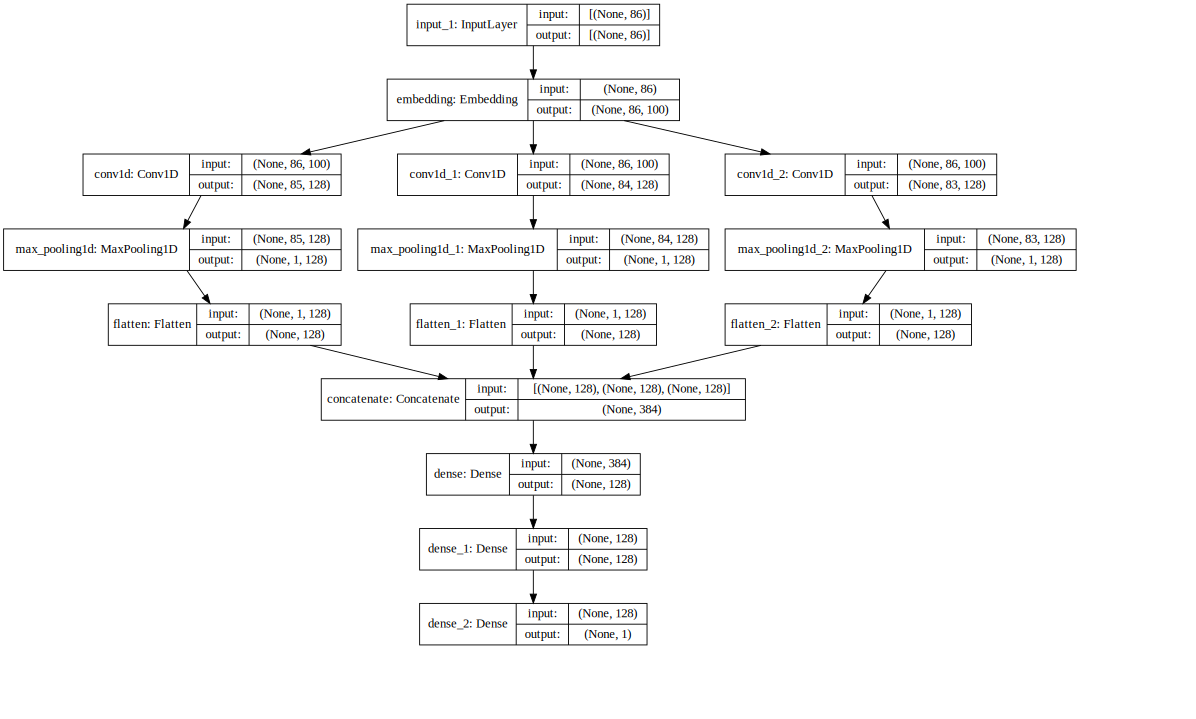

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

* compiler le model

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

* train le model

In [20]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
1722/1722 [==============================] - 58s 8ms/step - loss: 0.0143 - acc: 0.9925 - val_loss: 3.8462e-04 - val_acc: 0.9999
Epoch 2/10
1722/1722 [==============================] - 12s 7ms/step - loss: 9.1189e-04 - acc: 0.9998 - val_loss: 3.8759e-04 - val_acc: 0.9999
Epoch 3/10
1722/1722 [==============================] - 12s 7ms/step - loss: 7.7106e-04 - acc: 0.9998 - val_loss: 4.8251e-04 - val_acc: 1.0000
Epoch 4/10
1722/1722 [==============================] - 12s 7ms/step - loss: 8.5940e-04 - acc: 0.9998 - val_loss: 2.0102e-04 - val_acc: 0.9999
Epoch 5/10
1722/1722 [==============================] - 12s 7ms/step - loss: 2.9701e-04 - acc: 0.9999 - val_loss: 5.3717e-04 - val_acc: 0.9999
Epoch 6/10
1722/1722 [==============================] - 12s 7ms/step - loss: 5.0658e-04 - acc: 0.9998 - val_loss: 3.7497e-04 - val_acc: 0.9999
Epoch 7/10
1722/1722 [==============================] - 12s 7ms/step - loss: 3.3912e-04 - acc: 0.9999 - val_loss: 6.0473e-04 - val_acc: 0.9997
Epo

* evaluer le model sur test set

In [21]:
score = model.evaluate(X_test, y_test, verbose=1)

1076/1076 [==============================] - 4s 3ms/step - loss: 4.6319e-04 - acc: 0.9999


In [22]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.0004631898773368448
Test Accuracy: 0.9999128580093384


## **Comme vous pouvez voir nous avons atteindre une performance de 99,99% avec le CNN model** 

* Tracons la différence de loss et accuracy entre train set et test set

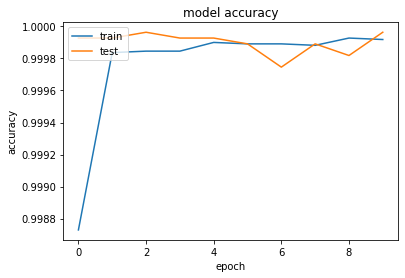

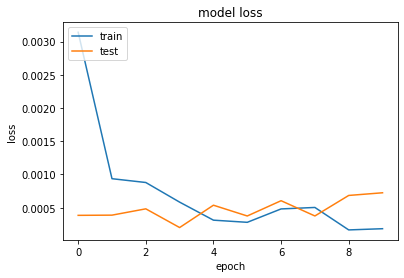

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# VI- LSTM

* Constriure le model

In [24]:
model1 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model1.add(embedding_layer)
model1.add(LSTM(128))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


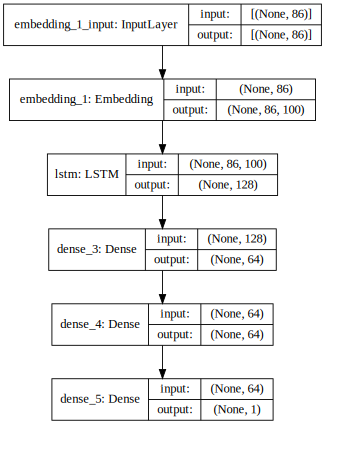

In [25]:
SVG(model_to_dot(model1, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

* train model

In [26]:
history = model1.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
1722/1722 [==============================] - 23s 10ms/step - loss: 0.0989 - acc: 0.9710 - val_loss: 0.1528 - val_acc: 0.9631
Epoch 2/10
1722/1722 [==============================] - 16s 9ms/step - loss: 0.1518 - acc: 0.9632 - val_loss: 0.1535 - val_acc: 0.9629
Epoch 3/10
1722/1722 [==============================] - 16s 9ms/step - loss: 0.1478 - acc: 0.9644 - val_loss: 0.1534 - val_acc: 0.9631
Epoch 4/10
1722/1722 [==============================] - 16s 9ms/step - loss: 0.1495 - acc: 0.9638 - val_loss: 0.1510 - val_acc: 0.9631
Epoch 5/10
1722/1722 [==============================] - 15s 9ms/step - loss: 0.1513 - acc: 0.9632 - val_loss: 0.1519 - val_acc: 0.9631
Epoch 6/10
1722/1722 [==============================] - 15s 9ms/step - loss: 0.1516 - acc: 0.9630 - val_loss: 0.1508 - val_acc: 0.9631
Epoch 7/10
1722/1722 [==============================] - 15s 9ms/step - loss: 0.1523 - acc: 0.9628 - val_loss: 0.1508 - val_acc: 0.9631
Epoch 8/10
1722/1722 [==============================] 

* evaluate model

In [27]:
score = model1.evaluate(X_test, y_test, verbose=1)

1076/1076 [==============================] - 4s 4ms/step - loss: 0.4748 - acc: 0.8161


In [28]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4748179316520691
Test Accuracy: 0.8160508871078491


## **Comme vous pouvez voir nous avons atteindre une performance de 81,60% avec le LSTM model**

* Tracons la différence de loss et accuracy entre train set et test set

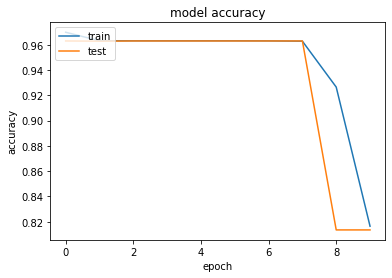

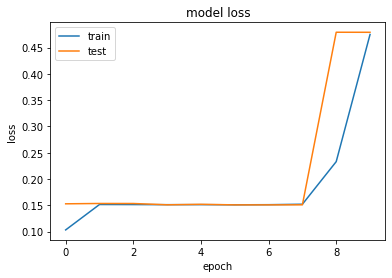

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()